In [1]:
#importation of libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import PIL
import pathlib
import tensorflow as tf
import numpy as np

import gradio as gr

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [6]:
dataset_path = "D:/github/sign_language_Classification_EfficientNet_Pretrained/data/Dataset/"

In [7]:
img_height,img_width,num_channel=224,224,3
batch_size=32
training_data = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2062 files belonging to 10 classes.
Using 1650 files for training.


In [8]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2062 files belonging to 10 classes.
Using 412 files for validation.


In [9]:
#Display the labels
class_names = training_data.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


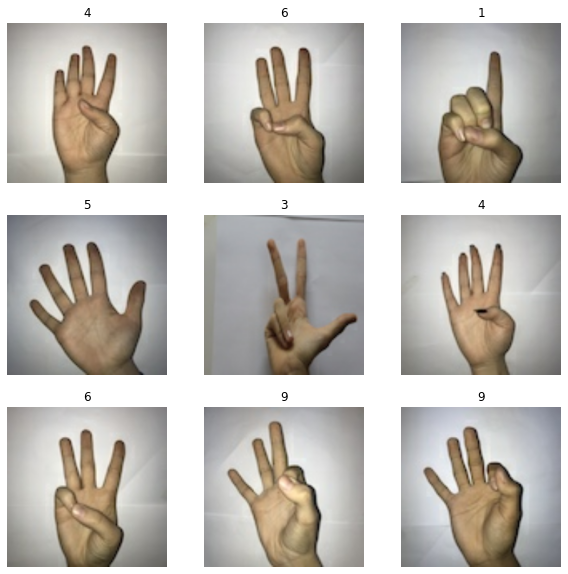

In [12]:
#Display images each label

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
# Setup the model
base_model = EfficientNetB0(weights='imagenet', include_top=False,input_shape=(img_width, img_height, num_channel))
num_classes = 10

x = base_model.output
x = Flatten()(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# transfer learning
for layer in base_model.layers:
    layer.trainable = False

#model.compile(optimizer='adam',loss='softmax',metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
epochs=10
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs)

Epoch 1/10
52/52 [==============================] - 31s 365ms/step - loss: 4.2232 - accuracy: 0.5374 - val_loss: 0.6331 - val_accuracy: 0.8981
Epoch 2/10
52/52 [==============================] - 8s 152ms/step - loss: 0.3137 - accuracy: 0.9395 - val_loss: 0.1585 - val_accuracy: 0.9587
Epoch 3/10
52/52 [==============================] - 8s 153ms/step - loss: 0.1303 - accuracy: 0.9663 - val_loss: 0.2043 - val_accuracy: 0.9612
Epoch 4/10
52/52 [==============================] - 8s 150ms/step - loss: 0.0768 - accuracy: 0.9835 - val_loss: 0.3663 - val_accuracy: 0.9175
Epoch 5/10
52/52 [==============================] - 8s 151ms/step - loss: 0.0940 - accuracy: 0.9767 - val_loss: 0.4284 - val_accuracy: 0.9296
Epoch 6/10
52/52 [==============================] - 7s 133ms/step - loss: 0.0797 - accuracy: 0.9796 - val_loss: 0.3415 - val_accuracy: 0.9539
Epoch 7/10
52/52 [==============================] - 7s 132ms/step - loss: 0.0822 - accuracy: 0.9808 - val_loss: 0.4115 - val_accuracy: 0.9320
Epoch

In [16]:
#Save the model
model.save('model_language_sign_classifier.h5')
print("Model saved successfully...!")

Model saved successfully...!


Ploting Training and Testing graph performance


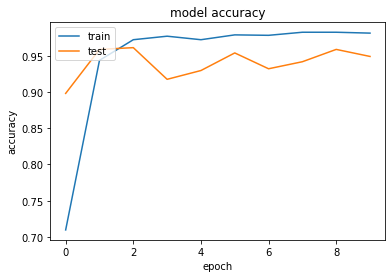

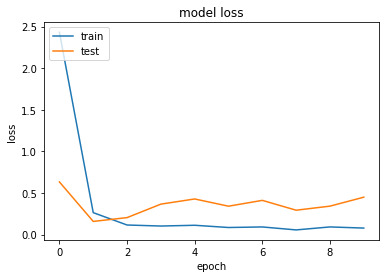

In [18]:
# Plot accuracy history 
print("Ploting Training and Testing graph performance")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./accuracy.png', dpi=100)

plt.show()


# Plot loss history 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./loss.png', dpi=100)
plt.show()

# INFERENCE

In [19]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def predict_image(img):
    #Load the model
    model=load_model('model_language_sign_classifier.h5')
    resize_image=img.reshape(-1,224,224,3)
    prediction=model.predict(resize_image)[0]
    return {class_names[i]: float(prediction[i]) for i in range(5)}

In [ ]:
image = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=5)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

Running locally at: http://127.0.0.1:7861/
To create a public link, set `share=True` in `launch()`.
Interface loading below...
